In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# setup plotting theme
from tufte_mpl import setup
setup()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [5]:
from neuron_populations import *

# Fixed vs. recurrent inhibition

## Excitatory population with self-coupling

$$\tau_k \dot h_k(t) = -h_k(t) + R_k \sum_n W_{kn} A_n(t) + R_k I_{ext,k}(t)$$

where

$$A_n(t) = \int_0^\infty \alpha_n(s) F_n(h_n(t-s)) \; \text{d}s$$

For each population $n$ :
- $\alpha(s)$ is the filtering kernel
- $F(h)$ is the gain function
- $A(t) = F(h(t))$ is the activity in the high noise (slow evolution) approximation
- $R$ the resistivity
- $W_{kn}$ the weight of currents from $n$ into $k$
- $I_{ext}(t)$ the external current
- $h(t)$ inner voltage of the population

TODO : verify these claims

### Varying constant $I_{ext}$

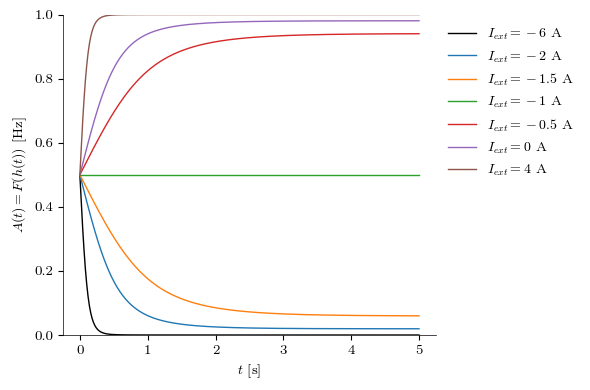

In [35]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Constant(I_ext))
	res = pop.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The activity levels out.

- $I_{ext} < -1 \; A$ : activity level decays to 0
- $I_{ext} = -1 \; A$ : threshold, activity level stays constant
- $I_{ext} > -1 \; A$ : activity level grows to 1

TODO : units of activity (Hz) ?

### Current spikes in steady state

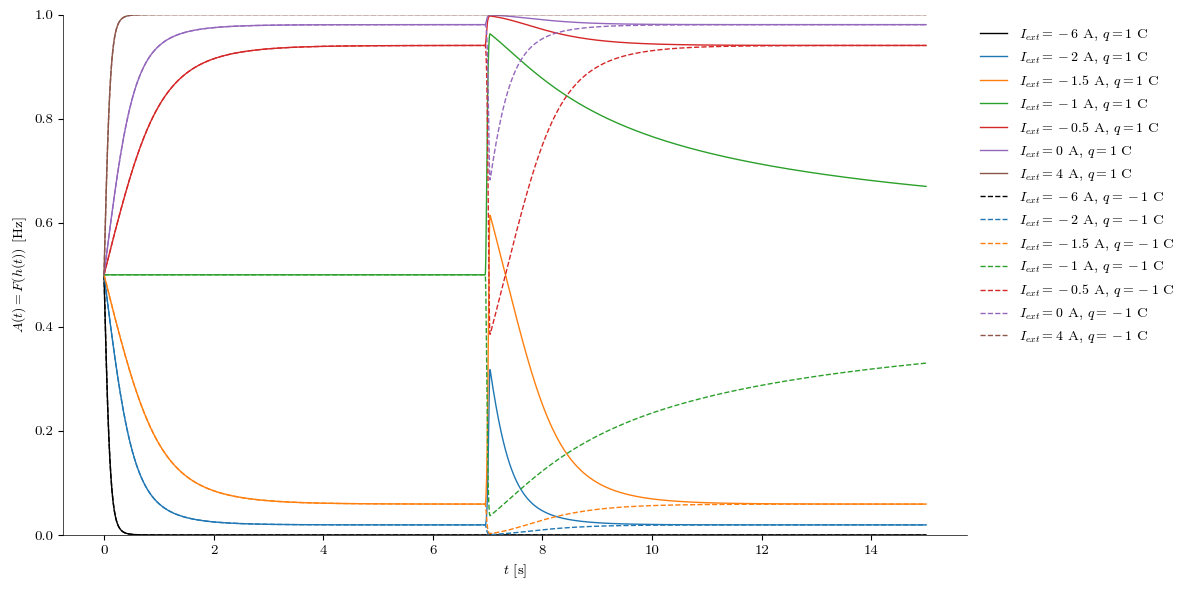

In [33]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
delta = Delta(7)

for iax, spike_charge in enumerate((1, -1)):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
		pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Constant(I_ext) + spike_charge*delta)
		res = pop.simulate_h(np.array([0]), (0, 15), dt_max=delta.eps/20)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, $q = {spike_charge}$ C', linestyle='-' if iax == 0 else '--')

# ax.axvline(delta.t0, linestyle='--')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Current spike affects (higher amplitude, more time to recovery) unsaturated neurons ($|A| < 1$) more than saturated ones ($|A| \approx 1$).

It is not symmetric : if $A > 1/2$, then for $q < 0$ the perturbation is greather than for $q > 0$ (and vice-versa)

### Effect of coupling strength

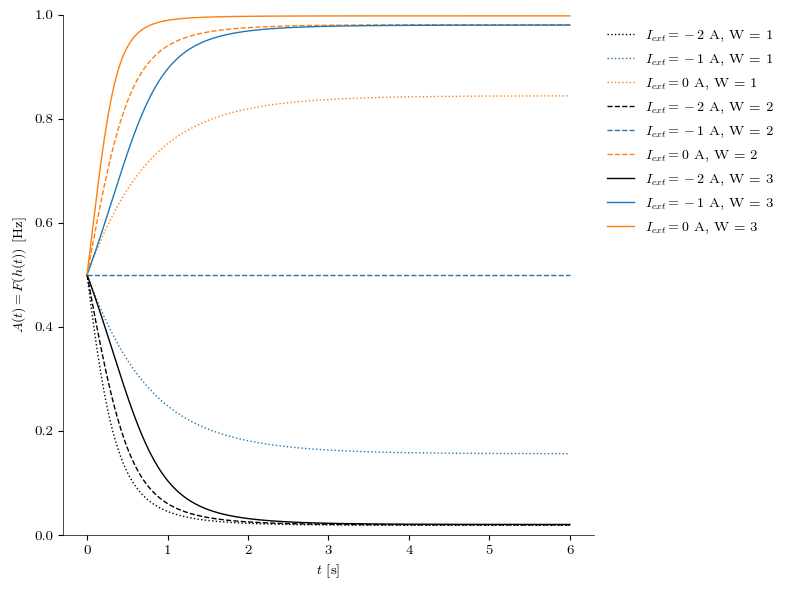

In [32]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for W in (1, 2, 3):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-2, -1, -0):
		pop = Populations(W=np.array([[W]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Constant(I_ext))
		res = pop.simulate_h(np.array([0]), (0, 6), dt_max=0.01)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, W = {W}', linestyle={1: 'dotted', 2: 'dashed', 3: 'solid'}.get(W))

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Changing coupling can change the equilibrium ($I_{ext} = 0 \; A$), but also the rate of convergence to the equilibrium ($I_{ext} = - 2 \; A$)
- Less coupling leads to less activity at all times

### Linear rate network

TODO : 
- does gain F apply to I_ext too ?
- how to apply last activation ? sigmoid or identity ?

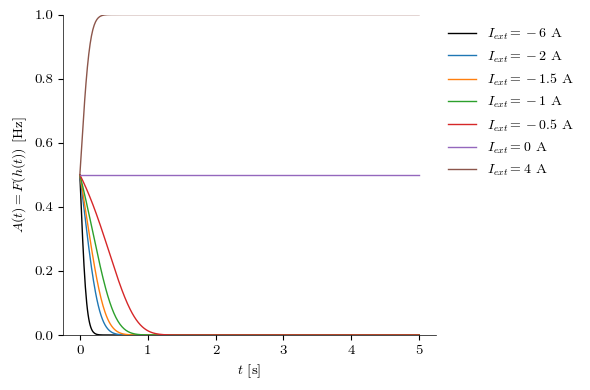

In [36]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-6, -2, -1.5, -1, -0.5, 0, 4):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=identity, I_ext=Constant(I_ext))
	res = pop.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	ax.plot(res.t, sigmoid(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Inhibitation-stabilized network

### Stability of the network as function of excitatory self-coupling

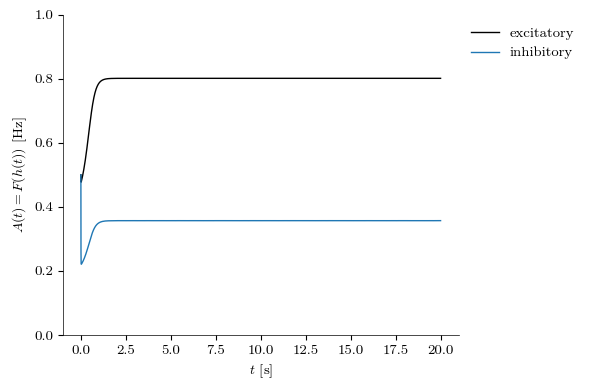

In [30]:
plt.close()
fig, ax = plt.subplots(dpi=100)

pop = Populations(W=np.array([[3.9, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=sigmoid, I_ext=Constant(np.array([-1, -1])))
res = pop.simulate_h(np.array([0, 0]), (0, 20), dt_max=0.01)
ax.plot(res.t, pop.gain_fn(res.y[0]), label='excitatory')
ax.plot(res.t, pop.gain_fn(res.y[1]), label='inhibitory')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TODO
- what is "exploding" ? it is one at A=1 and the other at A=0 ? what is "stable" ?
- what value for w_IE ? pick -w_EI for current conservation ?
- threshold w_EE ~= 3.86 good ?
- what current ?

### f-I curve

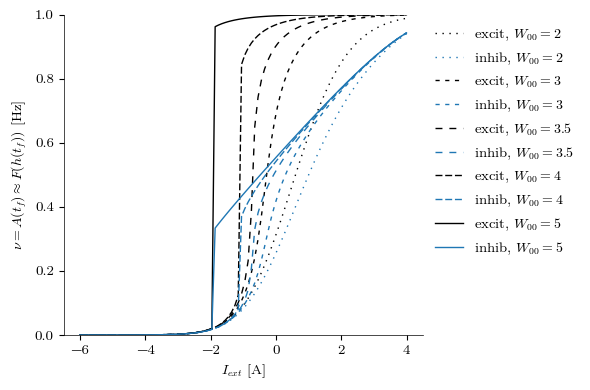

In [45]:
fig, ax = plt.subplots(dpi=100)
I_exts = np.linspace(-6, 4, 100)

for W00 in (2, 3, 3.5, 4, 5):
	fs = []
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in I_exts:
		pop = Populations(W=np.array([[W00, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=sigmoid, I_ext=Constant(np.array([I_ext, I_ext])))
		res = pop.simulate_h(np.array([0, 0]), (0, 2), dt_max=0.01)
		fs.append(pop.gain_fn(res.y[:, -1]))

	ax.plot(I_exts, fs, linestyle={2: (0, (1, 4)), 3: (0, (3, 4)), 3.5: (0, (5, 5)), 4: (0, (5, 2)), 5: 'solid'}.get(W00), label=[f'excit, $W_{{00}} = {W00}$', f'inhib, $W_{{00}} = {W00}$'])

ax.set_xlabel('$I_{ext}$ [A]')
ax.set_ylabel('$\\nu = A(t_f) \\approx F(h(t_f))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TODO : role of inhibitory population ?
- weak coupling : create a smooth transition ?
- strong coupling : prevent divergence ?